In [1]:
import gurobipy as gp
import numpy as np
import quarters
import companies
import pandas as pd
import numpy.linalg as la
from gurobipy import GRB
import plotly.express as px

In [8]:
def get_stock_weights(start_year, end_year, a, min_return):
    model = gp.Model('portfolio')
    model.params.NonConvex = 2
    model.setParam('NonConvex', 2)

    rfr = quarters.get_mean_rfr_between_years(start_year, end_year)
    gdp = quarters.get_gdp_growth_between_years(start_year, end_year)
    
    returns = pd.read_csv(f'./data/returns/returns_{start_year}-{end_year}.csv').set_index('Unnamed: 0')

    mu1 = returns.mean().to_numpy()
    mu2 = np.array([np.mean(rfr), np.mean(gdp)])
    #print(mu2)
    all_companies = returns.columns
    n_companies = returns.shape[1]

    #adding external parameters
    returns['avg_rfr'] = rfr
    returns['gdp_growth'] = gdp

    total_points = returns.shape[1]
    
    returns_array = returns.to_numpy().T.astype(float)
    cov_array = np.cov(returns_array)
    #print(cov_array)
    sigma11 = cov_array[0:n_companies, 0:n_companies]
    sigma21 = cov_array[n_companies:total_points, 0:n_companies]
    sigma12 = cov_array[0:n_companies, n_companies:total_points]
    sigma22 = cov_array[n_companies:total_points, n_companies:total_points]
    #print(sigma12, sigma22)
    mu = mu1 + sigma12@la.inv(sigma22)@(a-mu2)
    sigma = sigma11 - sigma12@la.inv(sigma22)@sigma21

    w = model.addMVar(n_companies, name='weights', lb=0)

    model.addConstr(mu@w == min_return, name='min_returns')
    model.addConstr(w.sum() ==  1, name='integrity')
    
    
    model.setObjective(w@sigma@w, GRB.MINIMIZE)
    model.write('./new_sol.lp')
    model.optimize()

    try:
        weights = w.X
        obj = model.ObjVal
    except:
        weights = None
        obj = 0
    return (weights, obj)

Set parameter NonConvex to value 2


In [9]:
from dev_email import send_email
import timeit

start = timeit.default_timer()

exp_array = [(i+50)/1000 for i in range(0, 300)]

results_dict = {}

for expectation in exp_array:
    results = get_stock_weights(1995, 2019, np.array([0.023734, 1.329796395805503/100]), expectation)
    variance = results[1]
    weights = results[0]
    results_dict[expectation] = {'variance':variance, 'weights':weights}

time = end-start
#send_email(f'\"Solving for optimal weights between 1995 and 2019. Took {time/60} minutes\"')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 2 rows, 134 columns and 268 nonzeros
Model fingerprint: 0x0099ef54
Model has 9045 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-06, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 134 columns
Presolve time: 0.00s

Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Model is infeasible or unbounded
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 4 rows, 268 columns and 536 nonzeros
Model fing

KeyboardInterrupt: 

In [28]:
benchmark = yf.Ticker('SPY').history(start=start_date_local)['Close']
total_portfolio = pd.DataFrame(index=benchmark.index)
total_portfolio['portfolio'] = markowitz.sum(axis=1)
total_portfolio['benchmark'] = benchmark/benchmark.iloc[0]
total_portfolio

,portfolio,benchmark
Date,,
2019-01-02 00:00:00-05:00,1.000000,1.000000
2019-01-03 00:00:00-05:00,0.933012,0.976137
2019-01-04 00:00:00-05:00,0.971389,1.008834
2019-01-07 00:00:00-05:00,0.978447,1.016788
2019-01-08 00:00:00-05:00,0.999499,1.026341
...,...,...
2023-10-10 00:00:00-04:00,3.874381,1.877126
2023-10-11 00:00:00-04:00,3.904786,1.884815
2023-10-12 00:00:00-04:00,3.922152,1.873324


In [20]:
import yfinance as yf
from dev_email import send_email
import datetime


start_year_local = 2019
start_date_local = datetime.datetime(year=start_year_local, month=1, day=1)


returns = pd.read_csv(f'./data/returns/returns_1995-2019.csv').set_index('Unnamed: 0')
all_companies = returns.columns

markowitz = pd.DataFrame(index=yf.Ticker('AAPL').history(start=start_date_local).index)

for i in range(len(all_companies)):
    
    company = all_companies[i]
    weight = results[i]
    history = yf.Ticker(company).history(start=start_date_local)['Close']
    
    adjusted = history/history.iloc[0]*weight
    
    markowitz[company] = adjusted

/tmp/ipykernel_7172/1206144772.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_7172/1206144772.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_7172/1206144772.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_7172/1206144772.py:23: Performance

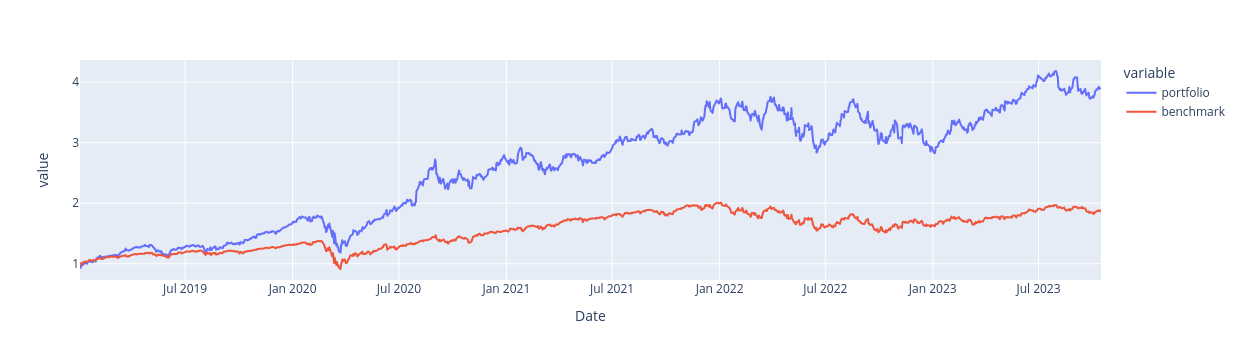

In [29]:
plot = px.line(total_portfolio)
plot.show()